In [1]:
from __future__ import print_function

from collections import defaultdict
import json
import requests

from IPython.display import Image
import networkx as nx

from py2cytoscape.util import from_networkx

In [2]:
def get_psiquic_uniprot(query, **kwargs):
    kwargs['format'] = kwargs.get('format', 'tab27')
    server = 'http://www.ebi.ac.uk/Tools/webservices/psicquic/uniprot/webservices/current/search/query'
    req = requests.get('%s/%s' % (server, query), params=kwargs)
    return req.content

In [3]:
genes_species = defaultdict(set)
interactions = {}

def get_gene_name(my_id, alt_names):
    toks = alt_names.split('|')
    for tok in toks:
        if tok.endswith('(gene name)'):
            return tok[tok.find(':') + 1: tok.find('(')]
    return my_id + '?'  # no name...

def get_vernacular_tax(tax):
    return tax.split('|')[0][tax.find('(') + 1:-1]

def add_interactions(species):
    for rec in species.split('\n'):
        toks = rec.rstrip().split('\t')
        if len(toks) < 15:
            continue  # empty line at the end
        id1 = toks[0][toks[0].find(':') + 1:]
        id2 = toks[1][toks[1].find(':') + 1:]
        gene1, gene2 = get_gene_name(id1, toks[4]), get_gene_name(id2, toks[5])
        #print(toks[6])

        tax1, tax2 = get_vernacular_tax(toks[9]), get_vernacular_tax(toks[10])
        inter_type = toks[11][toks[11].find('(') + 1:-1]
        miscore = float(toks[14].split(':')[1])
        genes_species[tax1].add(gene1)
        genes_species[tax2].add(gene2)
        interactions[((tax1, gene1), (tax2, gene2))] = {'score': miscore, 'type': inter_type}

In [4]:
human = get_psiquic_uniprot('uniprotkb:P04637')
add_interactions(human)
rat = get_psiquic_uniprot('uniprotkb:P10361')
add_interactions(rat)
mouse = get_psiquic_uniprot('uniprotkb:P02340')
add_interactions(mouse)

In [5]:
server = 'http://localhost:1234/v1'
#requests.delete(server + '/networks')

<Response [204]>

In [ ]:
def get_node_id(species, gene):
    if species == 'human':
        return gene
    elif species in ['mouse', 'rat']:
        return '%s (%s)' % (gene, species[0])
    else:
        return  '%s (%s)' % (gene, species)

graph = nx.MultiGraph()
for species, genes in genes_species.items():
    #print(species)
    for gene in genes:
        name = get_node_id(species, gene)
        #print(gene, name)
        graph.add_node(get_node_id(species, gene),
                       species=species, gene=gene)

for (i1, i2), attribs in interactions.items():
    tax1, gene1 = i1
    tax2, gene2 = i2
    #print(attribs)
    graph.add_edge(get_node_id(tax1, gene1),
                   get_node_id(tax2, gene2),
                   interaction=attribs['type'],
                   score=attribs['score'])

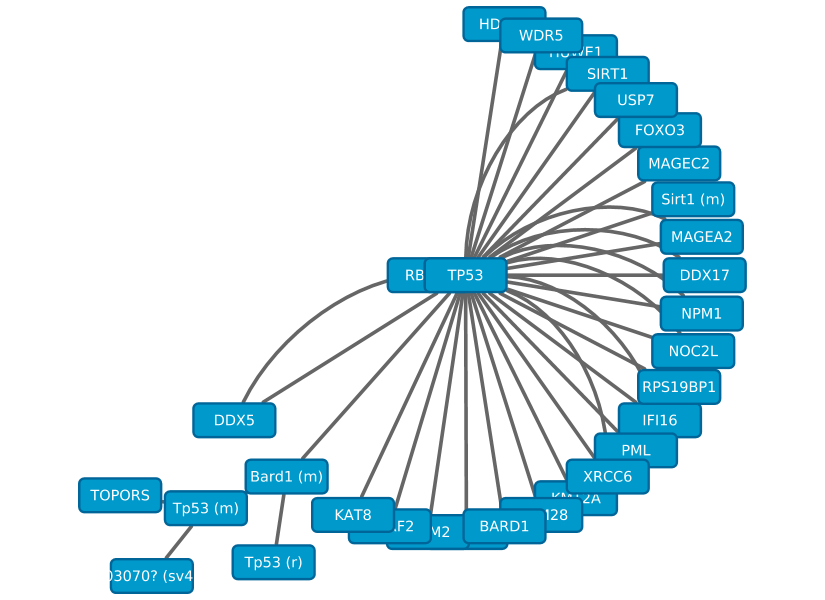

In [6]:
p53_interactions = from_networkx(graph)
p53_net = requests.post(server + '/networks', data=json.dumps(p53_interactions),
                        headers={'Content-Type': 'application/json'})
net_id = p53_net.json()['networkSUID']
requests.get('%s/apply/layouts/circular/%d' % (server, net_id))
Image('%s/networks/%d/views/first.png' % (server, net_id))

In [7]:
res = requests.get(server + '/networks',
                     headers={'Content-Type': 'application/json'})
print(res.content)

[52]


In [8]:
res = requests.get(server + '/apply/styles',
                     headers={'Content-Type': 'application/json'})
print(res.json())

[u'Directed', u'Nested Network Style', u'Universe', u'Ripple', u'BioPAX_SIF', u'default', u'Sample1', u'Big Labels', u'default black', u'BioPAX', u'Solid', u'Minimal']


In [9]:
res = requests.get(server + '/styles',
                     headers={'Content-Type': 'application/json'})
res.content
res = requests.get(server + '/styles/default',
                     headers={'Content-Type': 'application/json'})
print(json.dumps(json.loads(res.content), indent=4))

{
    "mappings": [
        {
            "mappingType": "passthrough", 
            "visualProperty": "NODE_LABEL", 
            "mappingColumnType": "String", 
            "mappingColumn": "name"
        }
    ], 
    "defaults": [
        {
            "visualProperty": "EDGE_BEND", 
            "value": ""
        }, 
        {
            "visualProperty": "EDGE_CURVED", 
            "value": true
        }, 
        {
            "visualProperty": "EDGE_LABEL", 
            "value": ""
        }, 
        {
            "visualProperty": "EDGE_LABEL_COLOR", 
            "value": "#000000"
        }, 
        {
            "visualProperty": "EDGE_LABEL_FONT_FACE", 
            "value": "Dialog.plain,plain,10"
        }, 
        {
            "visualProperty": "EDGE_LABEL_FONT_SIZE", 
            "value": 10
        }, 
        {
            "visualProperty": "EDGE_LABEL_TRANSPARENCY", 
            "value": 255
        }, 
        {
            "visualProperty": "EDGE_LINE_TYPE", 


In [10]:
ustyle = {
    'title': 'UniProt style',
    'mappings': [
        {'mappingType': 'discrete',
         'map': [
                {'key': 'human', 'value': '#00FF00'},
                {'key': 'rat', 'value': '#FF00FF'},
                {'key': 'mouse', 'value': '#00FFFF'}],
         'visualProperty': 'NODE_FILL_COLOR',
         'mappingColumnType': 'String',
         'mappingColumn': 'species'},
        {
            'mappingType': 'passthrough', 
            'visualProperty': 'NODE_LABEL', 
            'mappingColumnType': 'String', 
            'mappingColumn': 'gene'}, 
        {
            'mappingType': 'passthrough', 
            'visualProperty': 'EDGE_LABEL', 
            'mappingColumnType': 'String', 
            'mappingColumn': 'interaction'
        }],
    'defaults': [ {"visualProperty": "NODE_FILL_COLOR", 
            "value": "#FFFFFF"}]}

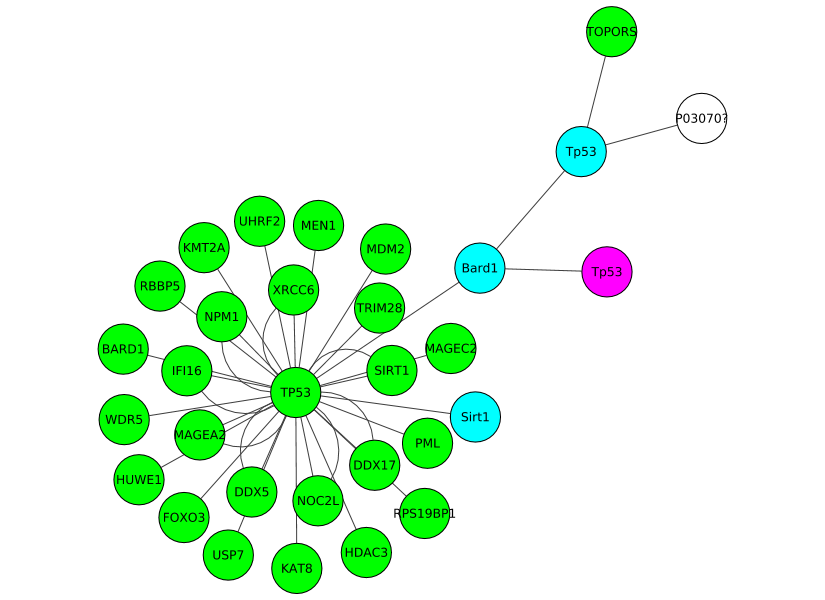

In [11]:
res = requests.post(server + "/styles", data=json.dumps(ustyle),
                   headers={'Content-Type': 'application/json'})

requests.get('%s/apply/layouts/force-directed/%d' % (server, net_id))
res = requests.get('%s/apply/styles/UniProt style/%d' % (server, net_id),
                     headers={'Content-Type': 'application/json'})
Image('%s/networks/%s/views/first.png' % (server, net_id))